In [1]:
%matplotlib inline
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import xarray as xr
from scipy.interpolate import interp1d

from mmctools.helper_functions import fit_powerlaw, theta
from mmctools.plotting import plot_timehistory_at_height

# Assess atmospheric conditions during June 2018 around ARM SGP site
Using the following Atmospheric Radiation Measurement (ARM) data products at the Southern Great Plains (SGP) facility:
* doppler lidar wind profiler, value-added product (`DLPROFWIND4NEWS`)
> Atmospheric Radiation Measurement (ARM) user facility. 2010, updated hourly. Doppler Lidar Profiles (DLPROFWIND4NEWS). 2018-06-03 to 2018-06-27, Southern Great Plains (SGP) Central Facility, Lamont, OK (C1). Compiled by D. Zhang and L. Riihimaki. ARM Data Center. Data set accessed 2020-09-04 at http://dx.doi.org/10.5439/1190027.
* surface meteorological station (`MET`)
> Atmospheric Radiation Measurement (ARM) user facility. 1993, updated hourly. Surface Meteorological Instrumentation (MET). 2018-06-03 to 2018-06-27, Southern Great Plains (SGP) Lamont, OK (Extended and Co-located with C1) (E13). Compiled by J. Kyrouac and D. Holdridge. ARM Data Center. Data set accessed 2020-09-04 at http://dx.doi.org/10.5439/1025220.
* eddy correlation flux measurement system (`30ECOR`)
> Atmospheric Radiation Measurement (ARM) user facility. 2003, updated hourly. Eddy Correlation Flux Measurement System (30ECOR). 2018-06-03 to 2018-06-27, Southern Great Plains (SGP) Lamont, OK (Extended, secondary) (E14). Compiled by R. Sullivan, D. Cook and E. Keeler. ARM Data Center. Data set accessed 2020-09-04 at http://dx.doi.org/10.5439/1025039.
* quality controlled eddy correlation flux measurement (`30QCECOR`) - see `June2018_compare_hfx_qc.ipynb`
> Atmospheric Radiation Measurement (ARM) user facility. 2003, updated hourly. Quality Controlled Eddy Correlation Flux Measurement (30QCECOR). 2018-06-03 to 2018-06-27, Southern Great Plains (SGP) Lamont, OK (Extended, secondary) (E14). Compiled by S. Xie and D. Cook. ARM Data Center. Data set accessed 2020-09-08 at http://dx.doi.org/10.5439/1097546.

In [2]:
startdate = pd.to_datetime('2018-06-03')
enddate = pd.to_datetime('2018-06-26')

In [3]:
lidar_datafiles = '/Users/equon/OneDrive - NREL/AWAKEN/ARM/dlprofwind4news/sgpdlprofwind4newsC1.c1.*.nc'
met_datafiles = '/Users/equon/OneDrive - NREL/AWAKEN/ARM/met/sgpmetE13.b1.*.cdf'
ecor_datafiles = '/Users/equon/OneDrive - NREL/AWAKEN/ARM/30ecor/sgp30ecorE14.b1.*.cdf'
qcecor_datafiles = '/Users/equon/OneDrive - NREL/AWAKEN/ARM/30qcecor/sgp30qcecorE14.s1.*.nc'

In [4]:
zhub = 80.0
D = 82.5

In [5]:
# measurement heights
met_wind_height = 10.0
ecor_wind_height = 3.0

In [6]:
# wind shear estimation
zmax = 200. # upper bound of lidar data to use for wind profile characerization
R2_cutoff = 0.9 # threshold for rejecting fit

## 1. Read data

### - lidar data

In [7]:
lidarfiles = glob.glob(lidar_datafiles)
lidar = xr.open_mfdataset(lidarfiles)

In [8]:
# update wind field names to match other datasets
lidar = lidar.rename_vars({'wind_speed':'wspd','wind_direction':'wdir'})

In [9]:
# resample to 30-min intervals for comparison with other data
%time lidar = lidar.resample(time='30min').mean()

# CPU times: user 37.6 s, sys: 311 ms, total: 37.9 s
# Wall time: 38.1 s

/Users/equon/anaconda3/envs/forge/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


CPU times: user 37.8 s, sys: 369 ms, total: 38.2 s
Wall time: 38.4 s


### - met mast

In [10]:
metfiles = glob.glob(met_datafiles)
met = xr.open_mfdataset(metfiles)

In [11]:
# update wind field names to match other datasets
met = met.rename_vars({'wspd_vec_mean':'wspd','wdir_vec_mean':'wdir'})

In [12]:
# resample to 30-min intervals for comparison with other data
%time met = met.resample(time='30min').mean()

# CPU times: user 1min 12s, sys: 533 ms, total: 1min 13s
# Wall time: 1min 13s

/Users/equon/anaconda3/envs/forge/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


CPU times: user 1min 15s, sys: 743 ms, total: 1min 15s
Wall time: 1min 16s


### - flux station

In [13]:
ecorfiles = glob.glob(ecor_datafiles)
ecor = xr.open_mfdataset(ecorfiles)

In [14]:
# update wind field names to match other datasets
ecor = ecor.rename_vars({'wind_spd':'wspd','wind_dir':'wdir'})

In [15]:
# use qc'd dataset for corrected heat fluxes
qcecorfiles = glob.glob(qcecor_datafiles)
qcecor = xr.open_mfdataset(qcecorfiles)

### - gather all wind-speed data

In [16]:
lidarwinds = lidar[['wspd','wdir']].sel(height=slice(0,zmax))
lidarheights = lidarwinds.coords['height'].values
lidarwinds = lidarwinds.sel(time=slice(startdate,enddate)).to_dataframe()
lidarwinds = lidarwinds.reorder_levels(['time','height']).sort_index()
len(lidarwinds.index.levels[0])

/Users/equon/anaconda3/envs/forge/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/equon/anaconda3/envs/forge/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1105

In [17]:
metwind = met[['wspd','wdir']].sel(time=slice(startdate,enddate))
metwind['height'] = met_wind_height
metwind = metwind.expand_dims(height=1).to_dataframe()
metwind = metwind.reorder_levels(['time','height']).sort_index()
len(metwind.index.levels[0])

1105

In [18]:
ecorwind = ecor[['wspd','wdir']].sel(time=slice(startdate,enddate))
ecorwind['height'] = ecor_wind_height
ecorwind = ecorwind.expand_dims(height=1).to_dataframe()
ecorwind = ecorwind.reorder_levels(['time','height']).sort_index()
len(metwind.index.levels[0])

1105

In [19]:
winds = pd.concat([ecorwind,metwind,lidarwinds])
winds = winds.sort_index()
os.makedirs('data',exist_ok=True)
winds.to_csv('data/combined_winds.csv')

In [20]:
missing = pd.isna(winds)
if np.any(missing):
    print(np.count_nonzero(missing),'missing data points to interpolate')
    winds = winds.unstack()
    winds = winds.interpolate(method='linear')
    winds = winds.stack()
    assert not np.any(pd.isna(winds))

26 missing data points to interpolate


## 2. Calculate additional quantities of interest

### - wind shear

In [21]:
zref = lidarwinds.index.levels[1].min()
print('zref =',zref)

zref = 90.93267059326172


In [22]:
# reshape data for power-law fit
df_heights = winds.unstack(level='time')
assert np.all(np.isfinite(df_heights.values))

In [23]:
%time alpha,R2 = fit_powerlaw(df_heights['wspd'],zref=zref)

# CPU times: user 9.04 s, sys: 32.1 ms, total: 9.07 s
# Wall time: 9.08 s

CPU times: user 9.57 s, sys: 88.6 ms, total: 9.66 s
Wall time: 9.74 s


In [24]:
alpha_clean = alpha.copy()
alpha_clean.loc[R2 < R2_cutoff] = np.nan
alpha_clean = alpha_clean.interpolate()

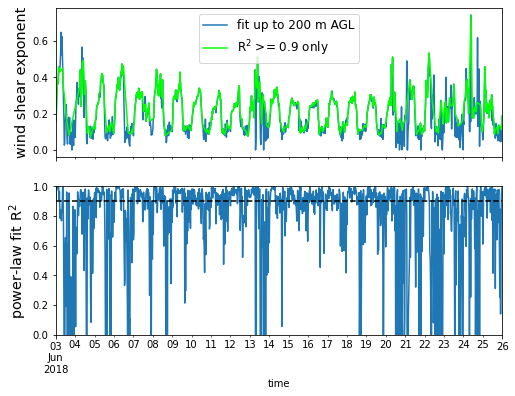

In [25]:
fig,ax = plt.subplots(nrows=2,sharex=True,figsize=(8,6))
alpha.plot(ax=ax[0],label=f'fit up to {zmax:g} m AGL')
alpha_clean.plot(ax=ax[0],color=(0,1,0),label=f'R$^2$ >= {R2_cutoff:g} only')
R2.plot(ax=ax[1])
ax[1].set_ylim((0,1))
ax[1].axhline(R2_cutoff,color='k',ls='--')
ax[0].set_xlabel('')
ax[0].set_ylabel('wind shear exponent', fontsize='x-large')
ax[1].set_ylabel('power-law fit R$^2$', fontsize='x-large')
ax[0].legend(loc='best',fontsize='large')

In [26]:
shear = xr.DataArray(
    alpha_clean,
    dims='time',
    attrs={
        'long_name': f'Shear exponent from power-law fit',
    },
    name='shear',
)

### - hub-height wind
from power-law fit

In [27]:
Uref = winds['wspd'].xs(zref, level='height')

In [28]:
# calculate hub-height wind speed from power-law fit
Uhub = xr.DataArray(
    Uref * (zhub/zref)**alpha_clean,
    dims='time',
    attrs={
        'long_name': f'Hub-height (z={zhub:g}) wind speed from power-law fit',
        'units': 'm/s',
    },
    name='wspd_hub',
)

In [29]:
wspd = lidar['wspd'].sel(height=zref).drop('height')
wspd.attrs['long_name'] = f'Wind speed near hub-height (z={zref:g}) from lidar'
wspd.attrs['units'] = 'm/s'

### - wind direction (change)

In [30]:
wdir = lidar['wdir'].sel(height=zref).drop('height')
wdir.attrs['long_name'] = f'Wind direction near hub-height (z={zref:g}) from lidar'
wdir.attrs['units'] = 'deg from north'

ztop = lidarheights[-1]
wdirtop = lidar['wdir'].sel(height=ztop).drop('height')

In [31]:
veer = xr.DataArray(
    100*(wdirtop-wdir)/(ztop-zref),
    dims='time',
    attrs={
        'long_name': f'Wind veer from lidar (z= {zref:g} to {ztop:g})',
        'units': 'deg/(100 m)',
    },
    name='veer',
)

/Users/equon/anaconda3/envs/forge/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


### - Monin-Obukhov length

In [32]:
# Need to workaround xarray quirk, e.g., when applying interpolate_na:
# ValueError: dimension 'time' on 0th function argument to apply_ufunc with dask='parallelized' consists of multiple chunks, but is also a core dimension. To fix, rechunk into a single dask array chunk along this dimension, i.e., ``.chunk({'time': -1})``, but beware that this may significantly increase memory usage.ustar
#ds = ecor.chunk({'time': ecor.sizes['time']})

In [33]:
ustar = ecor['ustar']#.interpolate_na(dim='time',method='linear')

In [34]:
# assume T_s is approximately equal to T_v -- will be off by a few %
thetav = theta(ecor['mean_t'], ecor['atm_pres'], p0=100.) # p in kPa
#thetav = thetav.interpolate_na(dim='time',method='linear')

In [35]:
# hfx = ds['cvar_wt'].interpolate_na(dim='time',method='linear')

# Calculate kinematic heat flux from QC'd data
hfx = qcecor['sensible_heat_flux'] / (ecor['rho']*1004.)
hfx.attrs['long_name'] = 'Kinematic heat flux'
hfx.attrs['units'] = 'K m/s'

In [36]:
L = -ustar**3 * thetav / (0.4*9.81*hfx)
L.name = 'L'
L.attrs['long_name'] = 'Monin-Obukhov length from ECOR at 3 m'
L.attrs['units'] = 'm'

In [37]:
z_L = 3.0 / L
z_L.name = 'z_over_L'
z_L.attrs['long_name'] = 'Monin-Obukhov stability parameter'
z_L.attrs['units'] = ''

### - stability classification
e.g., per criteria in St. Martin et al, Wind Energy Science, 2016

In [38]:
stability = np.empty_like(L,dtype='str')

In [39]:
stability[np.where(L > 0)] = 's'
stability[np.where(L < 0)] = 'u'
stability[np.where(np.abs(L) > 500)] = 'n'

In [40]:
stability = xr.DataArray(
    stability,
    dims='time',
    coords={'time':L.coords['time']},
    attrs={
        'long_name': 'Stability classification--unstable, neutral, or stable (u/n/s)--based on Obukhov length',
    },
    name='stability',
)

### - combine all atmospheric data

In [41]:
atmos = xr.Dataset({
    'wspd': wspd,
    'wdir': wdir,
    'Uhub': Uhub,
    'shear': shear,
    'veer': veer,
    'L': L,
    'z_L': z_L,
    'stability': stability,
    'ustar': ustar,
    'hfx': hfx,
})

In [42]:
os.makedirs('data',exist_ok=True)
atmos.to_netcdf('data/ARM_June2018_atmospheric_conditions.nc')

/Users/equon/anaconda3/envs/forge/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [45]:
df = atmos.to_dataframe()
df.to_csv('data/ARM_June2018_atmospheric_conditions.csv')

/Users/equon/anaconda3/envs/forge/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/equon/anaconda3/envs/forge/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


## 3. Plot data

Text(0, 0.5, 'occurrence [%]')

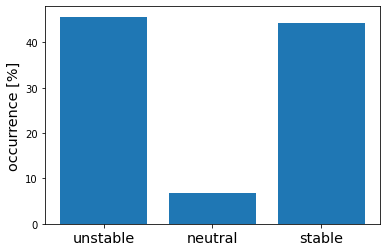

In [46]:
classes = ['unstable','neutral','stable']
Ntot = len(df)
fig,ax = plt.subplots()
for i,sc in enumerate(classes):
    count = len(df.loc[df['stability']==sc[0]])
    ax.bar(i,100*count/Ntot,color='tab:blue')
ax.set_xticks(np.arange(len(classes)))
ax.set_xticklabels(classes,fontsize='x-large')
ax.set_ylabel('occurrence [%]', fontsize='x-large')

/Users/equon/anaconda3/envs/forge/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/equon/anaconda3/envs/forge/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


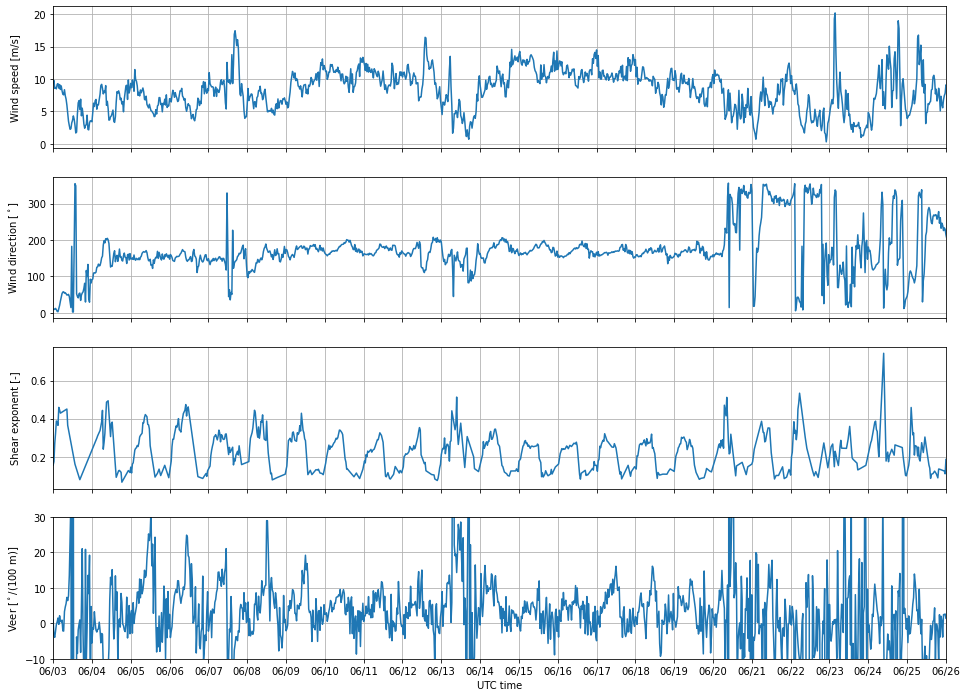

In [47]:
fig,ax = plot_timehistory_at_height(
    atmos, fields=['wspd','wdir','shear','veer'],
    fieldlabels={
        'shear': 'Shear exponent [-]',
        'veer': 'Veer [$^\circ$/(100 m)]',
    },
    fieldlimits={'veer':(-10,30)},
    timelimits=(startdate,enddate),
    subfigsize=(16,3),
)
ax[0].set_xticks([], minor=True)
ax[0].xaxis.set_major_locator(mdates.DayLocator())
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

/Users/equon/anaconda3/envs/forge/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/Users/equon/anaconda3/envs/forge/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


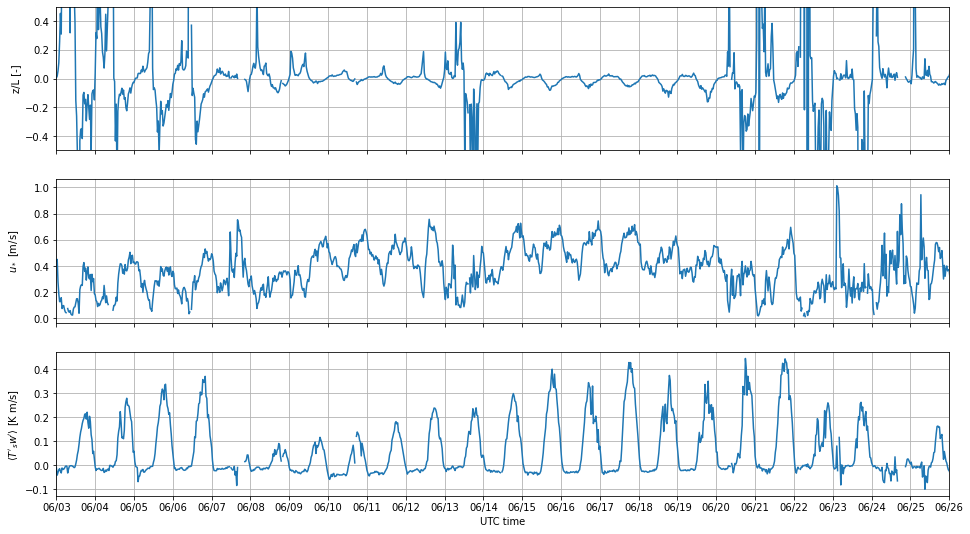

In [48]:
fig,ax = plot_timehistory_at_height(
    atmos, fields=['z_L','ustar','hfx'],
    fieldlabels={
        'z_L': 'z/L [-]',
        'ustar': '$u_*$ [m/s]',
        'hfx': r"$\langle T'_s w' \rangle$ [K m/s]",
    },
    fieldlimits={'z_L':(-0.5,0.5)},
    timelimits=(startdate,enddate),
    subfigsize=(16,3),
)
ax[0].set_xticks([], minor=True)
ax[0].xaxis.set_major_locator(mdates.DayLocator())
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))